## Introduction:

During this notebook, we will build a deep learning NLP text classifier model to classify movie reviews into positive or negative reviews. 

The dataset was obtained from [kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) and contains 50,000 movie and TV reviews from IMDB with an associated label of positive or negative. 

## Contents:

1. [Introduction](#introduction)
2. [Preprocessing](#prepro)
    1. [Remove stopwords/lemmatisation](#rem)
    2. [Tokenisation](#token)
    3. [Padding the text](#pad)
    5. [Train/Valid/Test split](#split)
3. [Building and training the model](#dev)
4. [Evaluation and conclusion](#eval)



In [1]:
#setup
import numpy as np
import pandas as pd

#machine learning
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#NLP
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#visuals
import matplotlib.pyplot as plt

#misc
import re

#check versions etc
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


Version:  2.3.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


### Loading dataset and preprocessing: <a name="prepo"></a>

In [2]:
#load datasets
train_df = pd.read_csv('imdb_dataset.csv',sep=',')

In [3]:
#switch sentiment to ones and zeroes
train_df['sent_bin'] = train_df['sentiment'].replace({'negative':0,'positive':1})

In [4]:
#check
train_df.head()

,review,sentiment,sent_bin
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


#### Remove stopwords, punctuation and lemmatise: <a name="rem"></a>

In [5]:
#clean each review, remove punctuation,lower case text, remove stop words and lemmatize
def preprocess(text):
        #clean text
        clean_data = []
        new_text = re.sub('<.*?>', '', text)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case, .upper() for upper          
        if new_text != '':
            clean_data.append(new_text)
        
        #print(clean_data)
        
        #remove stopwords
        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(clean_data[0]) 
        filtered_sentence = [] 
        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 
        #print(filtered_sentence)        
        
        #lemmatise
        lem_sentence = []
        lemmatizer = WordNetLemmatizer()
        for word in filtered_sentence:
            lem_sentence.append(lemmatizer.lemmatize(word))
        return(lem_sentence)



In [6]:
#apply text processing to all reviews in dataset
train_df['review_pre'] = train_df['review'].apply(preprocess)
#check a preprocessed review
train_df.review_pre[5]

['probably',
 'alltime',
 'favorite',
 'movie',
 'story',
 'selflessness',
 'sacrifice',
 'dedication',
 'noble',
 'cause',
 'preachy',
 'boring',
 'never',
 'get',
 'old',
 'despite',
 'seen',
 'time',
 'last',
 'year',
 'paul',
 'lukas',
 'performance',
 'brings',
 'tear',
 'eye',
 'bette',
 'davis',
 'one',
 'truly',
 'sympathetic',
 'role',
 'delight',
 'kid',
 'grandma',
 'say',
 'like',
 'dressedup',
 'midget',
 'child',
 'make',
 'fun',
 'watch',
 'mother',
 'slow',
 'awakening',
 'whats',
 'happening',
 'world',
 'roof',
 'believable',
 'startling',
 'dozen',
 'thumb',
 'theyd',
 'movie']

#### Tokenise reviews: <a name="token"></a>

In [7]:
#tokenise reviews
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token="<00V>")

tokenizer.fit_on_texts(train_df.review_pre.values)
word_index = tokenizer.word_index
word_index

{'<00V>': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'time': 6,
 'good': 7,
 'character': 8,
 'get': 9,
 'even': 10,
 'story': 11,
 'would': 12,
 'make': 13,
 'see': 14,
 'really': 15,
 'scene': 16,
 'much': 17,
 'well': 18,
 'people': 19,
 'great': 20,
 'bad': 21,
 'also': 22,
 'show': 23,
 'first': 24,
 'dont': 25,
 'way': 26,
 'thing': 27,
 'made': 28,
 'could': 29,
 'think': 30,
 'life': 31,
 'go': 32,
 'know': 33,
 'watch': 34,
 'love': 35,
 'many': 36,
 'seen': 37,
 'actor': 38,
 'two': 39,
 'plot': 40,
 'say': 41,
 'never': 42,
 'look': 43,
 'acting': 44,
 'end': 45,
 'little': 46,
 'best': 47,
 'year': 48,
 'ever': 49,
 'better': 50,
 'take': 51,
 'man': 52,
 'come': 53,
 'still': 54,
 'work': 55,
 'part': 56,
 'find': 57,
 'something': 58,
 'want': 59,
 'give': 60,
 'lot': 61,
 'back': 62,
 'director': 63,
 'im': 64,
 'real': 65,
 'guy': 66,
 'watching': 67,
 'doesnt': 68,
 'performance': 69,
 'didnt': 70,
 'play': 71,
 'woman': 72,
 'actually': 73,
 'though': 74,
 'f

In [8]:
#create array of tokenised reviews
tokenized = tokenizer.texts_to_sequences(train_df.review_pre.values)

In [9]:
#add tokenised review to df and count length of review
train_df['tokenised_reviews'] = tokenized
train_df['t_review_len'] = train_df['tokenised_reviews'].map(lambda x: len(x))
train_df.head()

,review,sentiment,sent_bin,review_pre,tokenised_reviews,t_review_len
0,One of the other reviewers has mentioned that ...,positive,1,"[one, reviewer, mentioned, watching, oz, episo...","[4, 1, 934, 67, 1, 175, 366, 1, 106, 496, 481,...",167
1,A wonderful little production. <br /><br />The...,positive,1,"[wonderful, little, production, filming, techn...","[291, 46, 238, 1, 1, 1, 1, 1, 60, 1, 423, 1, 1...",84
2,I thought this was a wonderful way to spend ti...,positive,1,"[thought, wonderful, way, spend, time, hot, su...","[97, 291, 26, 981, 6, 778, 1, 1, 1, 792, 1, 49...",85
3,Basically there's a family where a little boy ...,negative,0,"[basically, there, family, little, boy, jake, ...","[576, 132, 124, 46, 205, 1, 30, 132, 518, 1, 5...",66
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[petter, matteis, love, time, money, visually,...","[1, 1, 35, 6, 198, 1, 1, 3, 34, 281, 1, 691, 8...",125


count    50000.000000
mean       118.584700
std         89.251893
min          3.000000
25%         64.000000
50%         88.000000
75%        144.000000
max       1420.000000
Name: t_review_len, dtype: float64


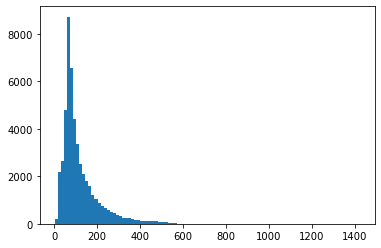

In [10]:
#check stats for review length
print(train_df.t_review_len.describe())

#check histrogram of review length
plt.hist(train_df.t_review_len.values,bins=100);

#### Pad tokenised reviews: <a name="pad"></a>

In [11]:
#pad the tokenised reviews to give uniform length
padded=pad_sequences(tokenized,padding='post',truncating='post',maxlen=300)

#### Train/valid/test split: <a name="split"></a>

In [12]:
#make train val test split
x_train, x_val_test, y_train, y_val_test = train_test_split(padded,train_df.sent_bin,
                                                            train_size=0.8, shuffle=True,)

x_val,x_test, y_val,y_test = train_test_split(x_val_test, y_val_test,
                                                            train_size=0.5, shuffle=True)

In [13]:
#check splits are as expected
print('xtrain: ',len(x_train))
print('ytrain: ',len(y_train))
print('xval: ',len(x_val))
print('yval: ',len(y_val))
print('xtest: ',len(x_test))
print('ytest: ',len(y_test))


xtrain:  40000
ytrain:  40000
xval:  5000
yval:  5000
xtest:  5000
ytest:  5000


### Develop the model: <a name="dev"></a>

#### Define the model:

In [24]:
#make the model
vocab_size = 1000 
embedding_dim = 64
rnn_units = 256
batch_size = 64

#different models tried

#gives val_acc around 0.834
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')])

# model = tf.keras.Sequential([
#   tf.keras.layers.Embedding(max_features + 1, embedding_dim),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.GlobalAveragePooling1D(),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1)])

# model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(max_features + 1, embedding_dim, batch_input_shape),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.GRU(rnn_units,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size),
#         tf.keras.layers.Dense(1),
#     ])




In [25]:
#set callbacks
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights = True)

callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

callbacks = [callback1,callback2]

In [26]:
#compile model
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

#### Train the model:

In [28]:
#tf.keras.backend.clear_session()

In [29]:
history = model.fit(x=x_train, y=y_train, batch_size=100, epochs=100, verbose=2, callbacks=callbacks,
    steps_per_epoch=10,validation_data=(np.asarray(x_val),np.asarray(y_val)),
    validation_steps=5,validation_freq=5,validation_batch_size=32,
    max_queue_size=10, workers=1, use_multiprocessing=False)


Epoch 1/100
10/10 - 14s - loss: 0.6945 - accuracy: 0.5050
Epoch 2/100
10/10 - 14s - loss: 0.6894 - accuracy: 0.5670
Epoch 3/100
10/10 - 17s - loss: 0.6912 - accuracy: 0.5990
Epoch 4/100
10/10 - 17s - loss: 0.6246 - accuracy: 0.7250
Epoch 5/100
10/10 - 18s - loss: 0.5679 - accuracy: 0.7290 - val_loss: 0.5027 - val_accuracy: 0.7812
Epoch 6/100
10/10 - 16s - loss: 0.5344 - accuracy: 0.7520
Epoch 7/100
10/10 - 15s - loss: 0.5269 - accuracy: 0.7520
Epoch 8/100
10/10 - 18s - loss: 0.5572 - accuracy: 0.7580
Epoch 9/100
10/10 - 15s - loss: 0.4774 - accuracy: 0.7880
Epoch 10/100
10/10 - 17s - loss: 0.4380 - accuracy: 0.8100 - val_loss: 0.4290 - val_accuracy: 0.7875
Epoch 11/100
10/10 - 19s - loss: 0.4331 - accuracy: 0.8000
Epoch 12/100
10/10 - 19s - loss: 0.4928 - accuracy: 0.7820
Epoch 13/100
10/10 - 20s - loss: 0.4196 - accuracy: 0.8200
Epoch 14/100
10/10 - 20s - loss: 0.4617 - accuracy: 0.7880
Epoch 15/100
10/10 - 21s - loss: 0.3815 - accuracy: 0.8390 - val_loss: 0.4539 - val_accuracy: 0.812

Epoch 49/100
10/10 - 13s - loss: 0.3515 - accuracy: 0.8440
Epoch 50/100
10/10 - 13s - loss: 0.3442 - accuracy: 0.8600 - val_loss: 0.3349 - val_accuracy: 0.8625
Epoch 51/100
10/10 - 13s - loss: 0.3878 - accuracy: 0.8320
Epoch 52/100
10/10 - 14s - loss: 0.3596 - accuracy: 0.8480


### Evaluate the model: <a name="eval"></a>

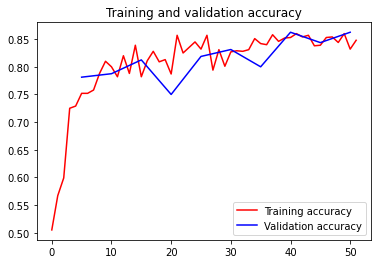

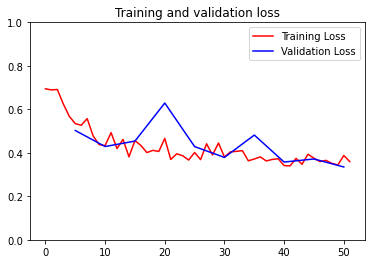

<Figure size 432x288 with 0 Axes>

In [30]:
#define variables of interest from history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(acc))
epochs2 = range(5,len(acc),5)

# #create graphs
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs2, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs2, val_loss, 'b', label='Validation Loss')
plt.ylim(0,1)
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

In [33]:
#make predictions on validation data
y_preds = model.predict(x_val)

#create a new dataframe with the predictions
df_y_preds = pd.DataFrame(y_preds)

#create a new dataframe with integers by rounding the previous values to 0 decimal places and converting to int type
df_y_preds_int = df_y_preds.round(0).astype(int)

[[2144  351]
 [ 391 2114]]


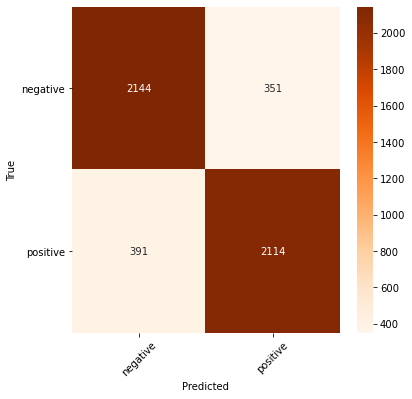

F1 score:  0.8507042253521127


In [38]:
from sklearn.metrics import confusion_matrix as cm
import seaborn 
labels = ['negative','positive']
conf_mat =cm(y_val,df_y_preds_int.values) 
print(conf_mat)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
seaborn.heatmap(conf_mat,annot=True,cmap='Oranges',fmt='g')
ax.set_xticklabels(labels,rotation=45)
ax.set_yticklabels(labels,rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import fbeta_score
print('F1 score: ',fbeta_score(y_val,df_y_preds_int.values,beta=1)) 

As we can see from the F1 score, the classifier is correctly predicting whether a movie review is negative or positive around 85% of the time and as shown in the confusion matrix, it can correctly classify most of the examples in the validation set.

We can see from the training graphs that it looks like loss is still decreasing and so it is possible that the classifier could be improved with a longer training time. 
